In [1]:
import torch
import torch.nn as nn
import torch.functional as F
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import json
from IPython.display import Image
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
import gc
import time
import torchvision
import random
from scipy.signal import convolve

In [2]:
new_size = 448
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(1)
torch.cuda.manual_seed(1)
np.random.seed(1)
random.seed(1)
plt.rcParams['figure.figsize'] = (7, 7)
device

device(type='cuda', index=0)

In [3]:
path_to_imgs = '/kaggle/input/train_val_images'
path = os.path.join(path_to_imgs, r'train_images')
img_ids = os.listdir(path)
files = [os.path.join(path, f) for f in img_ids]
path_to_bb_file = '/kaggle/input'
path_to_bounding_boxes = os.path.join(path_to_bb_file, r'TextOCR_0.1_train.json')
with open(path_to_bounding_boxes, 'r') as f:
    bounding_boxes = json.load(f)

In [4]:
def pad_img(img):
    """
    Pad image to square using pytorch, to the right or bottom
    """
    h, w = img.shape[-2:]
    if h > w:
        pad = h - w
        img = transforms.Pad((0, 0, pad, 0))(img)
    elif w > h:
        pad = w - h
        img = transforms.Pad((0, 0, 0, pad))(img)
    return img

def resize_img(img, size):
    """
    Resize image to square using pytorch
    """
    img = transforms.Resize(size, antialias=True)(img)
    return img

torch.Size([3, 768, 1024])
torch.Size([3, 1024, 1024])
torch.Size([3, 448, 448])


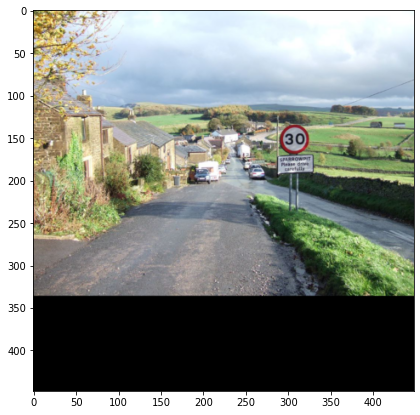

In [5]:
def make_it_cv2(img):
    img = img.permute(1, 2, 0)
    img = np.array(img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    return img

img = read_image(files[7])
print(img.shape)
img = pad_img(img)
print(img.shape)
img = resize_img(img, (new_size, new_size))
print(img.shape)
img = make_it_cv2(img)
cv2.imwrite('test.jpg', img)
plt.imshow(img)

In [6]:
def pre_process_image(img):
    h, w = img.shape[-2:]
    max_shape = max(h, w)
    ratio = new_size / max_shape
    img = pad_img(img)
    img = resize_img(img, (new_size, new_size))
    return img, ratio


tensor([[[112, 112, 112,  ...,   0,   0,   0],
         [112, 112, 112,  ...,   0,   0,   0],
         [112, 112, 112,  ...,   0,   0,   0],
         ...,
         [ 63,  63,  63,  ...,   0,   0,   0],
         [ 64,  64,  64,  ...,   0,   0,   0],
         [ 65,  65,  65,  ...,   0,   0,   0]],

        [[113, 113, 112,  ...,   0,   0,   0],
         [113, 112, 112,  ...,   0,   0,   0],
         [113, 112, 112,  ...,   0,   0,   0],
         ...,
         [ 59,  59,  60,  ...,   0,   0,   0],
         [ 63,  64,  64,  ...,   0,   0,   0],
         [ 66,  67,  67,  ...,   0,   0,   0]],

        [[106, 109, 115,  ...,   0,   0,   0],
         [107, 110, 115,  ...,   0,   0,   0],
         [109, 111, 114,  ...,   0,   0,   0],
         ...,
         [ 70,  68,  64,  ...,   0,   0,   0],
         [ 77,  75,  71,  ...,   0,   0,   0],
         [ 81,  79,  76,  ...,   0,   0,   0]]], dtype=torch.uint8)


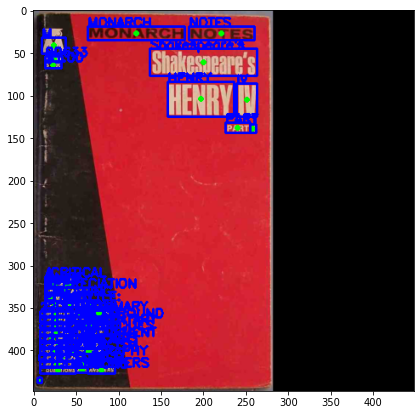

In [7]:
def get_bbox_resized(prebb, ratio):
    bb = prebb.copy()
    bb[0] = bb[0] * ratio
    bb[1] = bb[1] * ratio
    bb[2] = bb[2] * ratio
    bb[3] = bb[3] * ratio
    return bb
def get_middle_point(bb):
    x = (bb[0] + bb[2])/2
    y = (bb[1] + bb[3])/2
    return [x, y]
img_idx = 47
img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
img = read_image(files[img_idx])
img, ratio = pre_process_image(img)
print(img)
img = make_it_cv2(img)
for i in range(len(img_anns)):
    ann = bounding_boxes['anns'][img_anns[i]]
    points = ann['bbox']
    x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
    x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
    x1, y1, x2, y2 = int(x1), int(y1), int(x2), int(y2)
    middle_point = get_middle_point([x1, y1, x2, y2])
    cv2.circle(img, (int(middle_point[0]), int(middle_point[1])), 2, (0, 255, 0), 2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 2)
    cv2.putText(img, str(ann['utf8_string']), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 2)
cv2.imwrite('img_with_annotations.jpg', img)
plt.imshow(img)

In [8]:
idx_to_remove = []
for img_idx in range(len(files)):
    try:
        img_anns = bounding_boxes['imgToAnns'][img_ids[img_idx][:-4]]
    except KeyError:
        idx_to_remove.append(img_idx)
        continue

print('Number of images before removing images with no annotations: {}'.format(len(files)))
files = [i for j, i in enumerate(files) if j not in idx_to_remove]
img_ids = [i for j, i in enumerate(img_ids) if j not in idx_to_remove]
print('Number of images after removing images with no annotations: {}'.format(len(files)))

Number of images before removing images with no annotations: 25119
Number of images after removing images with no annotations: 21778


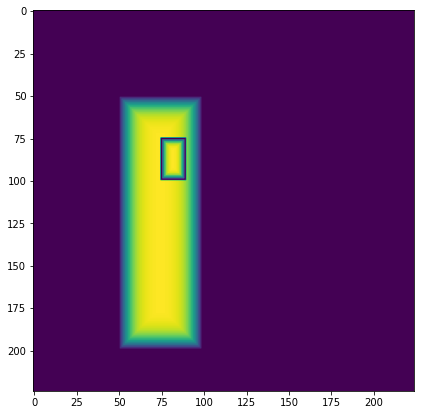

In [9]:
from scipy.stats import multivariate_normal

def from_bb2Label(bb_list):

    label = torch.zeros((new_size//2, new_size//2))
    for i in range(len(bb_list)):
        x1, y1, x2, y2 = bb_list[i][0], bb_list[i][1], bb_list[i][2], bb_list[i][3]
        x1, y1, x2, y2 = int(x1//2), int(y1//2), int(x2//2), int(y2//2)
        if x2 - x1 < 3 or y2 - y1 < 3:
            continue

        y, x = np.mgrid[y1:y2, x1:x2]
        dx = np.min(np.dstack((x2-1 - x, x - x1)), -1)
        dy = np.min(np.dstack((y2-1 - y, y - y1)), -1)
        D = np.min(np.dstack((dx, dy)), -1)
        L = np.max(D)
        a = 6
        saf = 2/(1 + np.e**(-a*D/L)) - 1

        label[y1:y2, x1:x2] = torch.tensor(saf)
    label = label.float()
    return label

plt.imshow(from_bb2Label([
                          [100, 100, 200, 400],
                         [150, 150, 180, 200]]))

In [10]:
from skimage import measure
from scipy import ndimage
offset = 0

def from_Tensor2BB(segmentation_maps, threshold=0.5):
    batches = []
    for i in range(len(segmentation_maps)):

        current_seg = segmentation_maps[i]
        current_seg = (current_seg - current_seg.min()) / (current_seg.max() - current_seg.min())
        
        binary_mask = current_seg > threshold

        labeled_mask, num_labels = ndimage.label(binary_mask)

        bounding_boxes = ndimage.find_objects(labeled_mask)
        bbs = []

        for label, bbox in enumerate(bounding_boxes, start=1):
            if bbox is not None:
                y1, y2, x1, x2 = bbox[0].start, bbox[0].stop, bbox[1].start, bbox[1].stop
                bbs.append((0, x1*2 - offset, y1*2 - offset, x2*2 + offset, y2*2 + offset))
        batches.append(bbs)

    return batches

In [11]:
files = np.array(files)
img_ids = np.array(img_ids)
os.chdir('/kaggle')
os.mkdir('tmp')
os.chdir('tmp')
os.mkdir('data')
os.chdir('data')
os.mkdir('features')
os.mkdir('labels')

data_set_size = 6000
train_size = 5000

imgpath_label = []
bboxes = []

imgpath_label_val = []
bboxes_val = []

for idx in range(data_set_size):
    img_path = files[idx]
    image = read_image(img_path)
    if image.shape[0] == 1:
        image = image.repeat(3, 1, 1)
    elif image.shape[0] != 3:
        image = image[:3]
    image, ratio = pre_process_image(image)

    img_anns = bounding_boxes['imgToAnns'][img_ids[idx][:-4]]
    bbs = []
    for i in range(len(img_anns)):
        ann = bounding_boxes['anns'][img_anns[i]]
        points = ann['bbox']
        x1, y1, x2, y2 = points[0], points[1], points[2] + points[0], points[3] + points[1]
        x1, y1, x2, y2 = get_bbox_resized([x1, y1, x2, y2], ratio)
        x1, y1, x2, y2 = np.clip(x1, 0, new_size), np.clip(y1, 0, new_size), np.clip(x2, 0, new_size), np.clip(y2, 0, new_size)

        bbs.append([x1, y1, x2, y2, ''])

    if idx < data_set_size - train_size:
        imgpath_label_val.append(f'/kaggle/tmp/data/features/{idx}')
        bboxes_val.append(bbs)
    else:
        imgpath_label.append(f'/kaggle/tmp/data/features/{idx}')
        bboxes.append(bbs)
    torchvision.io.write_jpeg(image, os.path.join('features', str(idx)))

    if (idx + 1) % 100 == 0:
        print(f'\r{idx + 1}/{len(files)}', end='', flush=True)


6000/21778

In [12]:
from torchvision import transforms
import random
import albumentations as A

transform = A.Compose([
    A.RandomCrop(width=new_size, height=new_size),
    A.RGBShift(p=1),
    A.Blur(blur_limit=9, p=0.4),
    A.RandomBrightnessContrast(p=0.2),
    A.CLAHE(p=0.5),
], bbox_params=A.BboxParams(format='pascal_voc'))

In [13]:
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import random

class CustomImageDataset(Dataset):
    def __init__(self, train):
        self.train = train

    def __len__(self):
        if self.train:
            return len(imgpath_label)
        else:
            return len(imgpath_label_val)

    def __getitem__(self, idx):
        if self.train:
            feature = cv2.imread(imgpath_label[idx])
            bb = bboxes[idx]
        else:
            feature = cv2.imread(imgpath_label_val[idx])
            bb = bboxes_val[idx]
        feature = cv2.cvtColor(feature, cv2.COLOR_BGR2RGB)
        if self.train:
            transformed = transform(image=feature, bboxes=bb)
            feature = transformed['image']
            bb = transformed['bboxes']
        feature = torch.tensor(feature).permute(2, 0, 1)
        label = from_bb2Label(bb)
        feature = feature/255.
        feature = feature.float()

        return feature, label, idx
    
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(0)
    
train_dataset = CustomImageDataset(True)
val_dataset = CustomImageDataset(False)

batch_size = 32
train_dataloader = DataLoader(train_dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=os.cpu_count(),
                              pin_memory=True,
                              worker_init_fn=seed_worker,
                              generator=g)
test_dataloader = DataLoader(val_dataset,
                             batch_size=batch_size,
                             shuffle=False,
                             num_workers=os.cpu_count(),
                             pin_memory=True,
                             worker_init_fn=seed_worker,
                             generator=g)
print(len(train_dataloader))
print(len(test_dataloader))

157
32


In [14]:
dropout = 0.0
factor = 1

class VggBlock(nn.Module):
    def __init__(self, in_ch, out_ch, maxpool=True):
        super(VggBlock, self).__init__()
        block = []
        for i in range(len(in_ch)):
            block.append(nn.Conv2d(in_ch[i], out_ch[i], kernel_size=3, padding=1, bias=False))
            block.append(nn.BatchNorm2d(out_ch[i]))
            block.append(nn.LeakyReLU(0.1, inplace=True))
            block.append(nn.Dropout2d(dropout, inplace=False))
        if maxpool:
            block.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        block_modules = nn.ModuleList(block)
        self.block = nn.Sequential(*block_modules)

    def forward(self, x):
        x = self.block(x)
        return x
    
class Vgg(nn.Module):
    def __init__(self):
        super(Vgg, self).__init__()
        self.conv1 = VggBlock([3, int(64*factor)], [int(64*factor), int(64*factor)])
        self.conv2 = VggBlock([int(64*factor), int(128*factor)], [int(128*factor), int(128*factor)])
        self.conv3 = VggBlock([int(128*factor), int(256*factor), int(256*factor)], [int(256*factor), int(256*factor), int(256*factor)])
        self.conv4 = VggBlock([int(256*factor), int(512*factor), int(512*factor)], [int(512*factor), int(512*factor), int(512*factor)])
        self.conv5 = VggBlock([int(512*factor), int(512*factor), int(512*factor)], [int(512*factor), int(512*factor), int(512*factor)])
        self.conv6 = VggBlock([int(512*factor), int(512*factor), int(512*factor)], [int(512*factor), int(512*factor), int(512*factor)], False)
        
    def forward(self, x):
        x = self.conv1(x)
        x1 = self.conv2(x)
        x2 = self.conv3(x1)
        x3 = self.conv4(x2)
        x4 = self.conv5(x3)
        x5 = self.conv6(x4)
        return x1, x2, x3, x4, x5
    
class Upconv(nn.Module):
    def __init__(self,in_ch, out_ch, upsample=True):
        super(Upconv, self).__init__()
        self.upsample = upsample
        layer = []
        layer.append(nn.Conv2d(in_ch, out_ch*2, kernel_size=1, padding=0, bias=False))
        layer.append(nn.BatchNorm2d(out_ch*2))
        layer.append(nn.LeakyReLU(0.1, inplace=True))
        layer.append(nn.Dropout2d(dropout, inplace=False))
        layer.append(nn.Conv2d(out_ch*2, out_ch, kernel_size=3, padding=1, bias=False))
        layer.append(nn.BatchNorm2d(out_ch))
        layer.append(nn.LeakyReLU(0.1, inplace=True))
        layer.append(nn.Dropout2d(dropout, inplace=False))
        
        layer_modules = nn.ModuleList(layer)
        self.layer = nn.Sequential(*layer_modules)
        
    def forward(self, x):
        if self.upsample:
            size = x.size()[2:]
            size = (size[0]*2, size[1]*2)
            x = nn.functional.interpolate(x, size=size, mode='bilinear', align_corners=False)
        x = self.layer(x)
        return x


class Model(nn.Module):
    def __init__(self, img_size, N, max_points_in_slice):
        super(Model, self).__init__()
        self.img_size = img_size
        self.N = N
        self.max_points_in_slice = max_points_in_slice
        self.vgg = Vgg()
        self.upconv1 = Upconv(int(1024*factor), int(256*factor))
        self.upconv2 = Upconv(int(768*factor), int(128*factor))
        self.upconv3 = Upconv(int(384*factor), int(64*factor))
        self.upconv4 = Upconv(int(192*factor), int(64*factor), True)
        self.conv_last = nn.Sequential(
            nn.Conv2d(int(64*factor), int(64*factor), kernel_size=3, padding=1), nn.BatchNorm2d(int(64*factor)), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(int(64*factor), int(64*factor), kernel_size=3, padding=1), nn.BatchNorm2d(int(64*factor)), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(int(64*factor), int(32*factor), kernel_size=3, padding=1), nn.BatchNorm2d(int(32*factor)), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(int(32*factor), int(32*factor), kernel_size=1), nn.BatchNorm2d(int(32*factor)), nn.LeakyReLU(0.1, inplace=True),
            nn.Conv2d(int(32*factor), 1, kernel_size=1)
        )
        

    def forward(self, x):
        vgg_outputs = self.vgg(x)
        y1 = torch.cat([vgg_outputs[3], vgg_outputs[4]], dim=1)
        y1 = self.upconv1(y1)
        
        y2 = torch.cat([y1, vgg_outputs[2]], dim=1)
        y2 = self.upconv2(y2)
        
        y3 = torch.cat([y2, vgg_outputs[1]], dim=1)
        y3 = self.upconv3(y3)
        
        y4 = torch.cat([y3, vgg_outputs[0]], dim=1)
        y4 = self.upconv4(y4)
        
        y = self.conv_last(y4)
        y = y.view(-1, new_size//2, new_size//2)

        return y

In [15]:
def show_progress(epoch, step, total_steps, loss, added_text='', width=30, bar_char='█', empty_char='░'):
    print('\r', end='')
    progress = ""
    for i in range(width):
        progress += bar_char if i < int(step / total_steps * width) else empty_char
    print(f"epoch:{epoch + 1} [{progress}] {step}/{total_steps} loss: {loss:.4f}" + added_text, end='')

In [17]:
epochs = 150
gc.collect()
torch.cuda.empty_cache()
model = Model()
model = nn.DataParallel(model, device_ids=[0, 1])
model.to(device)
print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-1, weight_decay=0.0005, momentum=0.9)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.95)

epoch = 0
best_val_acc = 0

24.313377 M parameters


In [19]:
def estimate_acc(predictions, labels, thresh=0.85):
    B = predictions.shape[0]
    detected_areas = torch.zeros(B, new_size, new_size)
    labeled_areas = torch.zeros(B, new_size, new_size)
    num_of_boxes_predicted = torch.zeros(B)
    num_of_boxes_labeled = torch.zeros(B)
    
    predictions_bb = from_Tensor2BB(predictions.detach().cpu(), thresh)
#     test_labels_bb = from_Tensor2BB(labels.detach().cpu())
    labels = [[[0] + bb[:-1] for bb in b] for b in labels]
    test_labels_bb = labels
    predictions_bb = [torch.tensor(batch) for batch in predictions_bb]
    test_labels_bb = [torch.round(torch.tensor(batch)).int() for batch in test_labels_bb]

    for b in range(B):
        detected = predictions_bb[b]
        if detected.shape[0] == 0:
            continue
        x1 = detected[..., 1]
        y1 = detected[..., 2]
        x2 = detected[..., 3]
        y2 = detected[..., 4]
        
        for i in range(detected.shape[0]):
            detected_areas[b, y1[i]:y2[i], x1[i]:x2[i]] = 1.0
        num_of_boxes_predicted[b] = float(detected.shape[0])

        detected = test_labels_bb[b]
        if detected.shape[0] == 0:
            continue
        x1 = detected[..., 1]
        y1 = detected[..., 2]
        x2 = detected[..., 3]
        y2 = detected[..., 4]
        
        for i in range(detected.shape[0]):
            labeled_areas[b, y1[i]:y2[i], x1[i]:x2[i]] = 1.0
        num_of_boxes_labeled[b] = float(detected.shape[0])
        
    iou = detected_areas * labeled_areas
    xor = torch.max(detected_areas, labeled_areas) - iou
    n1 = torch.min(num_of_boxes_predicted, num_of_boxes_labeled)
    n2 = torch.max(num_of_boxes_predicted, num_of_boxes_labeled)
    iou_sum = torch.sum(iou, dim=(1, 2))
    xor_sum = torch.sum(xor, dim=(1, 2))
    labeled_sum = torch.sum(labeled_areas, dim=(1, 2))
    acc = (iou_sum*n1) / (torch.max((labeled_sum + xor_sum)*n2, torch.ones(B)))
    return torch.mean(acc, dim=0)

In [20]:
@torch.no_grad()
def estimate_loss(thresh=0.85):
    model.eval()
    running_loss = 0.0
    iters = 0
    acc = 0
    for x, y, bb_idx in test_dataloader:
        iters += 1
        x = x.to(device)
        y = y.to(device)
        with torch.autocast('cuda'):
            output = model.forward(x)
            loss_val = loss(output, y)
        x.detach()
        output.detach()
        y.detach()
        running_loss += loss_val.item()
        acc += estimate_acc(output.contiguous(), [bboxes_val[k] for k in bb_idx], thresh)
    val_loss = running_loss / iters
    acc /= iters
    model.train()
    return val_loss, acc

In [79]:
model.train()
while epoch < epochs:
    running_loss = 0.0
    acc = 0.0
    start = time.time()
    for i, (x, y, bb_idx) in enumerate(train_dataloader):
        x = x.to(device)
        y = y.to(device)
        optimizer.zero_grad(set_to_none=True)
        with torch.autocast('cuda'):
            output = model.forward(x)
            loss_val = loss(output, y)
        loss_val.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        x.detach()
        y.detach()
        output.detach()
        with torch.no_grad():
            running_loss += loss_val.item()
            acc += estimate_acc(output.contiguous(), [bboxes[k] for k in bb_idx])
            show_progress(epoch, i, len(train_dataloader), running_loss/(i + 1), f' train acc: {acc/(i + 1):.4f}')
    with torch.no_grad():
        acc /= len(train_dataloader)
        val_loss, val_acc = estimate_loss()
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            torch.save(model.state_dict(), '/kaggle/working/saved_model.pth') # save model weights
        show_progress(epoch, i, len(train_dataloader), running_loss/(i + 1), f' train acc: {acc:.4f}' + f' val loss: {val_loss:.4f} acc: {val_acc:.4f}' + f' time: {time.time() - start:.4f}')
        print()
    epoch += 1
    scheduler.step()

epoch:42 [█████████████████████████████░] 156/157 loss: 41.2278 train acc: 0.2346 val loss: 49.2201 acc: 0.1454 time: 196.9543
epoch:44 [█████████████████████████████░] 156/157 loss: 41.0589 train acc: 0.2365 val loss: 49.8986 acc: 0.1411 time: 195.6845
epoch:45 [█████████████████████████████░] 156/157 loss: 41.0575 train acc: 0.2392 val loss: 49.9568 acc: 0.1523 time: 196.4046
epoch:46 [█████████████████████████████░] 156/157 loss: 41.0322 train acc: 0.2423 val loss: 49.3782 acc: 0.1696 time: 196.5706
epoch:47 [█████████████████████████████░] 156/157 loss: 40.9862 train acc: 0.2441 val loss: 49.8303 acc: 0.1696 time: 196.4419
epoch:48 [█████████████████████████████░] 156/157 loss: 40.9350 train acc: 0.2452 val loss: 49.9337 acc: 0.1601 time: 195.3290
epoch:49 [█████████████████████████████░] 156/157 loss: 40.9432 train acc: 0.2476 val loss: 51.4691 acc: 0.1367 time: 197.0372
epoch:50 [█████████████████████████████░] 156/157 loss: 40.8868 train acc: 0.2462 val loss: 50.7227 acc: 0.1551

KeyboardInterrupt: 

best = 0.1668

In [ ]:
checkpoint = torch.load('/kaggle/working/saved_model.pth')
model.load_state_dict(checkpoint)

In [80]:
# validation
val_loss, val_acc = estimate_loss(thresh=0.9)
print(f"val loss: {val_loss} val acc: {val_acc}")

val loss: 51.508454859256744 val acc: 0.1190931499004364


In [81]:
del x
del y
del output

In [82]:
test_dataloader_iter = iter(test_dataloader)

In [83]:
model.eval()
test_features, test_labels, bb_idx = next(test_dataloader_iter)
test_features = test_features.to(device)
with torch.autocast('cuda'):
    predictions = model.forward(test_features)

In [84]:
predictions_bb = from_Tensor2BB(predictions.detach().cpu().numpy(), 0.85)
test_labels_bb = [bboxes_val[k] for k in bb_idx]
idx = 0

In [78]:
# del model
del test_features
del test_labels
del predictions

NameError: name 'test_features' is not defined

5


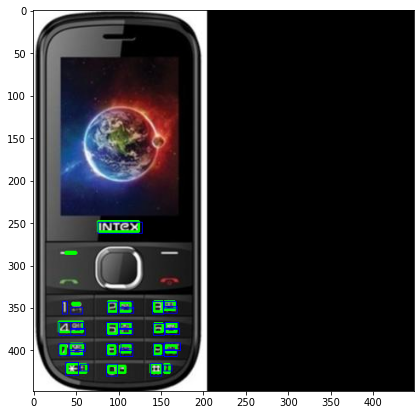

In [91]:
idx += 1
test_features = test_features.cpu()
img = make_it_cv2(test_features[idx])

bounding_boxes_preds = predictions_bb[idx]
for box in bounding_boxes_preds:
    _, x1, y1, x2, y2 = box
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    

bounding_boxes_labels = test_labels_bb[idx]
for box in bounding_boxes_labels:
    x1, y1, x2, y2, _ = box
    x1, y1, x2, y2 = round(x1), round(y1), round(x2), round(y2)
    cv2.rectangle(img, (x1, y1), (x2, y2), (0, 0, 255), 1)
    
cv2.imwrite('test.jpg', img)
plt.imshow(img)
print(idx)
j = -1

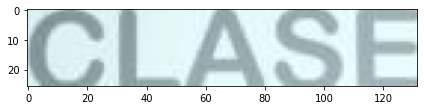

In [29]:
j += 1
img = make_it_cv2(test_features[idx])
_, x1, y1, x2, y2 = bounding_boxes_preds[j]
offset = 0
plt.imshow(img[y1 - offset:y2 + offset, x1 - offset:x2 + offset])

tensor(6.1445)
tensor(-0.5835)


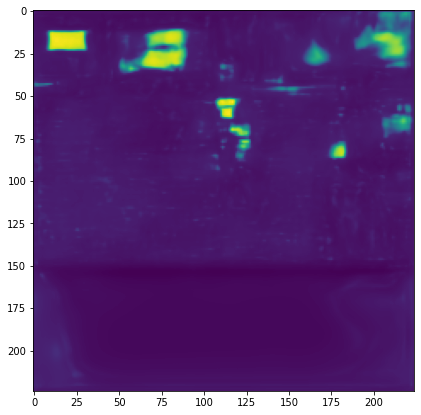

In [90]:
heatmap = predictions[idx].detach().cpu().float()
print(heatmap.max())
print(heatmap.min())
heatmap = (heatmap - heatmap.min()) / (heatmap.max() - heatmap.min())

plt.imshow(heatmap, )

In [ ]:
plt.imshow(test_labels[idx].detach().cpu())